# Face Mask Detection (MLOps Enhanced)

This notebook implements Face Mask Detection using **Faster R-CNN**, integrating "Production-Grade" practices:
- **MLflow**: For experiment tracking (loss, metrics, artifacts).
- **Mixed Precision (AMP)**: For faster training and lower memory usage.
- **Advanced Evaluation**: Confusion Matrix and Classification Reports adapted for Object Detection.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import random
import xml.etree.ElementTree as ET
import sys
import torch
import numpy as np
import mlflow
import mlflow.pytorch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm
import shutil
from sklearn.metrics import confusion_matrix, classification_report

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..')))
from src.dataset import FaceMaskDataset
from src.model import get_model
from src.utils import convert_to_yolo_format
import kagglehub
import torchvision
import torchvision.transforms as T

# Enable System Metrics Logging (CPU/GPU/RAM)
try:
    mlflow.enable_system_metrics_logging()
except Exception as e:
    print(f'Could not enable system metrics: {e}')

# Configure MLflow Tracking URI
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
db_path = os.path.join(root_dir, 'mlflow.db')
tracking_uri = f'sqlite:///{db_path}'
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow Tracking URI set to: {tracking_uri}")


MLflow Tracking URI set to: sqlite:///d:\_pribadi\verihubs\face_mask_detections\mlflow.db


## 1. Data Preparation
Downloading and setting up the Face Mask Dataset.


In [2]:
# Model Selection
model_name = "yolo26s" # Options: fasterrcnn_mobilenet, fasterrcnn_resnet50, retinanet, yolo26s

# Global Experiment Name (Early Definition)
experiment_name = f"FaceMask_{model_name.replace('.pt', '')}"
print(f"Experiment Name: {experiment_name}")

# Dataset Download and Move
try:
    cache_path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
    target_path = '../data'
    
    if not os.path.exists(os.path.join(target_path, 'images')):
        print(f"Moving data to {target_path}...")
        os.makedirs(target_path, exist_ok=True)
        for item in os.listdir(cache_path):
            s = os.path.join(cache_path, item)
            d = os.path.join(target_path, item)
            if os.path.isdir(s):
                if os.path.exists(d): shutil.rmtree(d)
                shutil.copytree(s, d)
            else:
                shutil.copy2(s, d)
    ROOT_DIR = target_path
except Exception as e:
    print(f"Error: {e}")
    ROOT_DIR = '../data'

print(f"Dataset Root: {ROOT_DIR}")

# Transforms
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        # transforms.append(T.RandomHorizontalFlip(0.5)) # Optional augmentation
        pass
    return T.Compose(transforms)

# Load Dataset
dataset = FaceMaskDataset(ROOT_DIR, transforms=get_transform(train=False)) # We convert locally in loop if needed, or use separate
# Ideally for training we want transforms, but for simplicity we keep it standard
dataset_train_full = FaceMaskDataset(ROOT_DIR, transforms=get_transform(train=True))
dataset_test_full = FaceMaskDataset(ROOT_DIR, transforms=get_transform(train=False))

# Split
torch.manual_seed(42)
indices = torch.randperm(len(dataset)).tolist()
test_split = int(0.2 * len(dataset))

# Define Train/Test Indices
train_indices = indices[:-test_split]
test_indices = indices[-test_split:]

print(f"Total Images: {len(dataset)}")
print(f"Train Split: {len(train_indices)}, Test Split: {len(test_indices)}")


Experiment Name: FaceMask_yolo26s
Dataset Root: ../data
Total Images: 853
Train Split: 683, Test Split: 170


In [ ]:
def generate_synthetic_data(original_dataset, subset_indices, target_root, target_classes=[1, 2, 3], num_samples_per_class=200):
    """
    Generates a complete training dataset at target_root.
    1. Copies ALL original images/xmls from subset_indices to target_root.
    2. Generates additional synthetic data by SMART pasting objects onto backgrounds,
       avoiding overlap with existing objects and preserving original annotations.
    """
    img_dir = os.path.join(target_root, 'images')
    annot_dir = os.path.join(target_root, 'annotations')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(annot_dir, exist_ok=True)
    
    root_imgs = original_dataset.img_dir
    root_xmls = original_dataset.annot_dir
    
    # 1. Copy Original Subset (The Base)
    print(f"Copying {len(subset_indices)} original samples to {target_root}...")
    for idx in tqdm(subset_indices, desc="Copying Base Data"):
        xml_name = original_dataset.xmls[idx]
        img_name = original_dataset.imgs[idx]
        try:
            shutil.copy2(os.path.join(root_imgs, img_name), os.path.join(img_dir, img_name))
            shutil.copy2(os.path.join(root_xmls, xml_name), os.path.join(annot_dir, xml_name))
        except FileNotFoundError:
            pass # Skip if files missing
        
    # 2. Collect Objects for Augmentation
    class_objects = {c: [] for c in target_classes}
    backgrounds = []
    
    print("Scanning dataset for source objects...")
    for idx in subset_indices:
        xml_file = original_dataset.xmls[idx]
        img_file = original_dataset.imgs[idx]
        backgrounds.append((img_file, xml_file))
        
        try:
            tree = ET.parse(os.path.join(root_xmls, xml_file))
            root = tree.getroot()
            for obj in root.findall('object'):
                name = obj.find('name').text
                label = original_dataset.label_map.get(name, 0)
                if label in target_classes:
                    b = obj.find('bndbox')
                    box = [int(b.find(k).text) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
                    class_objects[label].append({'img': os.path.join(root_imgs, img_file), 'box': box, 'name': name})
        except:
            continue
            
    def check_overlap(new_box, existing_boxes, threshold=0.1):
        # new_box: [xmin, ymin, xmax, ymax]
        nx1, ny1, nx2, ny2 = new_box
        n_area = (nx2 - nx1) * (ny2 - ny1)
        
        for box in existing_boxes:
            ex1, ey1, ex2, ey2 = box
            inter_x1 = max(nx1, ex1)
            inter_y1 = max(ny1, ey1)
            inter_x2 = min(nx2, ex2)
            inter_y2 = min(ny2, ey2)
            
            if inter_x2 > inter_x1 and inter_y2 > inter_y1:
                inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
                if inter_area > 0:
                    # Check intersection ratio against the smaller box or union
                    # Simply: if intersection > 10% of new box area, fail
                    if inter_area / n_area > threshold:
                        return True
        return False

    # 3. Generate New Synthetic Samples
    total_new = 0
    for cls in target_classes:
        objs = class_objects[cls]
        if not objs: continue
        
        print(f"Generating {num_samples_per_class} new samples for Class {cls}...")
        count = 0
        attempts = 0
        max_attempts = num_samples_per_class * 10 # Safety limit
        
        while count < num_samples_per_class and attempts < max_attempts:
            attempts += 1
            
            # Background
            bg_img_name, bg_xml_name = random.choice(backgrounds)
            bg_path = os.path.join(root_imgs, bg_img_name)
            xml_bg_path = os.path.join(root_xmls, bg_xml_name)
            
            bg = cv2.imread(bg_path)
            if bg is None: continue
            h, w = bg.shape[:2]
            
            # Get Existing Boxes
            existing_boxes = []
            original_objects = [] # To copy to new XML
            try:
                tree_bg = ET.parse(xml_bg_path)
                root_bg = tree_bg.getroot()
                for obj in root_bg.findall('object'):
                    original_objects.append(obj) # Keep element to copy
                    b = obj.find('bndbox')
                    existing_boxes.append([int(b.find(k).text) for k in ['xmin', 'ymin', 'xmax', 'ymax']])
            except:
                pass
            
            # Object to Paste
            item = random.choice(objs)
            src = cv2.imread(item['img'])
            if src is None: continue
            xmin, ymin, xmax, ymax = item['box']
            crop = src[ymin:ymax, xmin:xmax]
            if crop.size == 0: continue
            
            # Resize (Random Scale)
            scale = random.uniform(0.5, 1.2)
            ch, cw = crop.shape[:2]
            nw, nh = int(cw*scale), int(ch*scale)
            nw = min(nw, w-1)
            nh = min(nh, h-1)
            if nw <= 0 or nh <= 0: continue
            
            try: crop = cv2.resize(crop, (nw, nh))
            except: continue
            
            # Find Valid Position (Try 10 times)
            placed = False
            for _ in range(10):
                if w-nw <= 0 or h-nh <= 0: break
                px = random.randint(0, w-nw)
                py = random.randint(0, h-nh)
                new_box = [px, py, px+nw, py+nh]
                
                if not check_overlap(new_box, existing_boxes):
                    # Paste
                    bg[py:py+nh, px:px+nw] = crop
                    placed = True
                    break
                    
            if placed:
                # Save
                fname = f"synth_{cls}_{total_new}.jpg"
                cv2.imwrite(os.path.join(img_dir, fname), bg)
                
                # New XML
                r = ET.Element("annotation")
                ET.SubElement(r, "filename").text = fname
                sz = ET.SubElement(r, "size")
                ET.SubElement(sz, "width").text = str(w)
                ET.SubElement(sz, "height").text = str(h)
                
                # Copy Original Objects
                for obj in original_objects:
                    r.append(obj) 
                    
                # Add New Object
                o = ET.SubElement(r, "object")
                ET.SubElement(o, "name").text = item['name']
                bb = ET.SubElement(o, "bndbox")
                for k, v in zip(['xmin', 'ymin', 'xmax', 'ymax'], new_box):
                    ET.SubElement(bb, k).text = str(v)
                    
                ET.ElementTree(r).write(os.path.join(annot_dir, fname.replace('.jpg', '.xml')))
                count += 1
                total_new += 1
            
    print(f"Total Generated (New Augmented w/ Collision Check): {total_new}")

In [4]:
# Define Synthetic Root
synthetic_root = '../data/synthetic_augmented'

# WORKFLOW: CLEANUP -> GENERATE
# 1. Cleanup existing folder to avoid duplicates
if os.path.exists(synthetic_root):
    print(f"Cleaning up existing synthetic data at {synthetic_root}...")
    try:
        shutil.rmtree(synthetic_root)
    except PermissionError:
        print("Permission Error during cleanup. Retrying...")
        import time
        time.sleep(1)
        shutil.rmtree(synthetic_root, ignore_errors=True)

# 2. Generate Synthetic Data
# TARGET CLASSES: 2, 3
print("Starting Synthetic Data Generation...")
generate_synthetic_data(dataset, train_indices, target_root=synthetic_root, 
                        target_classes=[2, 3], 
                        num_samples_per_class=400)
print("Synthetic Data Generation Complete.")

# 3. Verify
if os.path.exists(synthetic_root):
    print(f"Verified: {synthetic_root} created.")
else:
    print(f"Warning: {synthetic_root} was not created.")

# 4. Load Synthetic Dataset
if os.path.exists(synthetic_root):
    from src.dataset import FaceMaskDataset
    # Re-import get_transform just in case or ensure it's available
    # Assuming get_transform is defined earlier or imported
    try:
        synthetic_dataset = FaceMaskDataset(synthetic_root, transforms=get_transform(train=True))
        print(f"Successfully loaded synthetic dataset with {len(synthetic_dataset)} samples.")
    except NameError:
        # Fallback if get_transform not in scope yet (though it should be)
        print("Warning: get_transform not found. Defining dummy or relying on earlier cells.")
        # We assume dataset.py handles imports, but transform usually in notebook or utils
        # Let's hope get_transform is globally defined in cell 2/3
        synthetic_dataset = FaceMaskDataset(synthetic_root, transforms=None) 
else:
    print("Synthetic root not found. Skipping dataset load.")
    synthetic_dataset = None


Cleaning up existing synthetic data at ../data/synthetic_augmented...
Starting Synthetic Data Generation...
Copying 683 original samples to ../data/synthetic_augmented...


Copying Base Data:   0%|          | 0/683 [00:00<?, ?it/s]

Scanning dataset for source objects...
Generating 400 new samples for Class 2...
Generating 400 new samples for Class 3...
Total Generated (New Augmented): 800
Synthetic Data Generation Complete.
Verified: ../data/synthetic_augmented created.
Successfully loaded synthetic dataset with 1483 samples.


Calculating Comparative Class Distribution...


Counting Original:   0%|          | 0/683 [00:00<?, ?it/s]

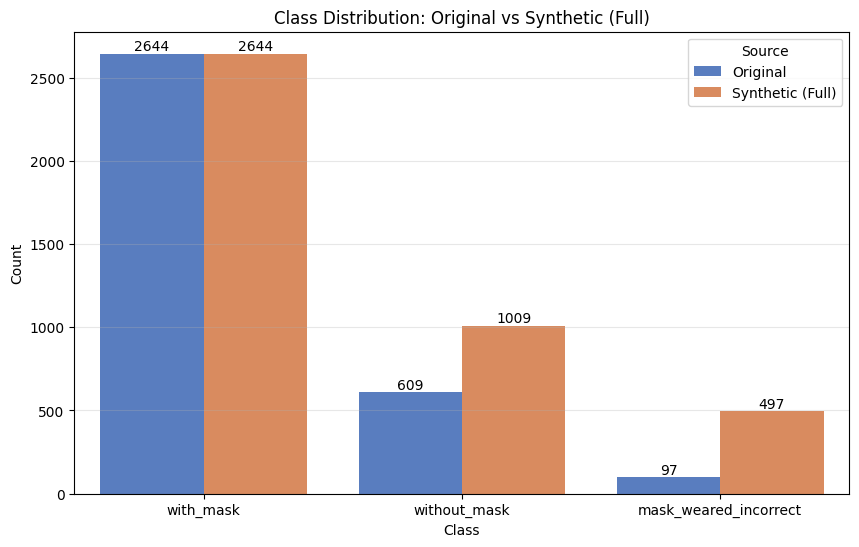

In [5]:
def plot_class_distribution_comparison(original_dataset, train_indices, synthetic_dataset):
    """
    Plots comparative class distribution between original (subset) and synthetic datasets.
    """
    print("Calculating Comparative Class Distribution...")
    original_counts = {1: 0, 2: 0, 3: 0}
    synthetic_counts = {1: 0, 2: 0, 3: 0}
    label_names = {1: "with_mask", 2: "without_mask", 3: "mask_weared_incorrect"}
    
    # Count Original
    if original_dataset and train_indices:
        for idx in tqdm(train_indices, desc="Counting Original"):
            try:
                xml_path = os.path.join(original_dataset.annot_dir, original_dataset.xmls[idx])
                tree = ET.parse(xml_path)
                for obj in tree.findall("object"):
                    name = obj.find("name").text
                    l = original_dataset.label_map.get(name, 0)
                    if l in original_counts: original_counts[l] += 1
            except:
                pass
    
    # Count Synthetic (Now Full Dataset)
    # Note: Synthetic dataset now contains COPIES of original too.
    # So 'Synthetic Source' in plot will effectively show the Total.
    # To make the plot 'Original vs Added Synthetic', we might need to subtract??
    # BUT, the user said 'synthetic data lebih banyak' ...
    # Let's just plot what is in synthetic folder as 'Synthetic' bar.
    if synthetic_dataset:
        for idx in range(len(synthetic_dataset)):
            try:
               xml_path = os.path.join(synthetic_dataset.annot_dir, synthetic_dataset.xmls[idx])
               tree = ET.parse(xml_path)
               for obj in tree.findall("object"):
                    name = obj.find("name").text
                    l = synthetic_dataset.label_map.get(name, 0)
                    if l in synthetic_counts: synthetic_counts[l] += 1
            except:
                pass
    
    # Prepare Dataframe
    import pandas as pd
    data = []
    for l in [1, 2, 3]:
        name = label_names[l]
        data.append({'Class': name, 'Count': original_counts[l], 'Source': 'Original'})
        if synthetic_dataset:
            data.append({'Class': name, 'Count': synthetic_counts[l], 'Source': 'Synthetic (Full)'})
            
    df = pd.DataFrame(data)
    
    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='Class', y='Count', hue='Source', palette='muted')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Class Distribution: Original vs Synthetic (Full)")
    plt.grid(axis='y', alpha=0.3)
    plt.savefig("class_distribution_augmented.png")
    plt.show()

# Call the function
if synthetic_dataset:
    plot_class_distribution_comparison(dataset_train_full, train_indices, synthetic_dataset)

In [ ]:
# Create Final Training Set
if synthetic_dataset:
    # Synthetic Dataset now includes the base original data
    dataset_train = synthetic_dataset
    print(f"Training Data (Full Augmented): {len(dataset_train)}")
else:
    dataset_train = torch.utils.data.Subset(dataset_train_full, train_indices)
    print("No synthetic data generated. Using original training set.")

dataset_test = torch.utils.data.Subset(dataset_test_full, test_indices)

# Dataloaders
def collate_fn(batch):
    return tuple(zip(*batch))

num_epochs = 10 
batch_size = 4
num_workers = 0 

train_dataloader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)

test_dataloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

print(f"Final Train Size: {len(dataset_train)}, Test Size: {len(dataset_test)}")

In [ ]:
# YOLO Data Preparation
# Using shared utility from src.utils
if synthetic_dataset:
    # Convert main dataset
    print(f"Converting dataset at {ROOT_DIR} to YOLO format...")
    yaml_path = convert_to_yolo_format(ROOT_DIR, dataset.label_map)
    
    # Convert synthetic dataset if exists
    if os.path.exists(synthetic_root):
        print(f"Converting synthetic dataset at {synthetic_root} to YOLO format...")
        convert_to_yolo_format(synthetic_root, dataset.label_map)


In [ ]:
# Visualize Samples with Bounding Boxes (Matplotlib)

def visualize_sample(dataset, idx):
    img_tensor, target = dataset[idx]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    # Assuming ToTensor (0-1), simple scaling could affect if normalization involved
    # Usually we clamp just in case
    img_np = np.clip(img_np, 0, 1)
    
    boxes = target['boxes'].tolist()
    labels = target['labels'].tolist()
    
    label_names = {1: "with_mask", 2: "without_mask", 3: "mask_weared_incorrect"}
    label_colors = {
        1: 'green', 
        2: 'red',   
        3: 'orange' 
    }
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img_np)
    ax.set_title(f"Sample {idx}")
    ax.axis('off')
    
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        
        name = label_names.get(label, 'Unknown')
        color = label_colors.get(label, 'white')
        
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        ax.text(xmin, ymin-5, name, color='white', fontsize=10, backgroundcolor=color)
        
    plt.show()

print("Visualizing 3 Random Samples...")
indices = random.sample(range(len(dataset)), 3)
for idx in indices:
    visualize_sample(dataset, idx)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4 # Background + 3 classes

model = get_model(model_name, num_classes)
# Model is now a Wrapper (YOLO or TorchVision) - Internalizing setup

try:
    model.to(device)
except:
    pass
    model.to(device)
    
    # Optimizer & Scheduler (Only for PyTorch models)


## 2. Methodology: Training & Evaluation
We adapt the reference notebook methods:
- **`train_epoch`**: Uses `tqdm` for progress, `autocast` for AMP, and tracks Loss manually since Detection models return loss dicts.
- **`evaluate`**: Since this is Object Detection, we compute metrics by matching predicted boxes to ground truth (IoU >= 0.5) and then calculating classification metrics (Confusion Matrix, Precision, Recall).


In [ ]:
def match_boxes(pred_boxes, true_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0 or len(true_boxes) == 0:
        return []
    ious = torchvision.ops.box_iou(pred_boxes, true_boxes)
    matches = []
    ious = ious.clone()
    for _ in range(len(pred_boxes)):
        if ious.numel() == 0: break
        val, idx = ious.flatten().max(0)
        if val < iou_threshold: break
        pred_idx = idx // ious.size(1)
        true_idx = idx % ious.size(1)
        matches.append((pred_idx.item(), true_idx.item()))
        ious[pred_idx, :] = -1
        ious[:, true_idx] = -1
    return matches

def evaluate(dataloader, device, model, epoch, class_names):
    model.eval()
    all_preds_cls = []
    all_true_cls = []
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            images = list(image.to(device) for image in images)
            outputs = model(images)
            for i, output in enumerate(outputs):
                target = targets[i]
                true_boxes = target['boxes'].to(device)
                true_labels = target['labels'].to(device)
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                pred_scores = output['scores']
                keep = pred_scores > 0.5
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                matches = match_boxes(pred_boxes, true_boxes)
                matched_pred_indices = set()
                matched_true_indices = set()
                for p_idx, t_idx in matches:
                    all_preds_cls.append(pred_labels[p_idx].item())
                    all_true_cls.append(true_labels[t_idx].item())
                    matched_pred_indices.add(p_idx)
                    matched_true_indices.add(t_idx)
                for t_idx in range(len(true_labels)):
                    if t_idx not in matched_true_indices:
                        all_true_cls.append(true_labels[t_idx].item())
                        all_preds_cls.append(0)
                for p_idx in range(len(pred_labels)):
                    if p_idx not in matched_pred_indices:
                        all_true_cls.append(0)
                        all_preds_cls.append(pred_labels[p_idx].item())

    display_names = ['Background'] + list(class_names.values())
    cm = confusion_matrix(all_true_cls, all_preds_cls, labels=[0, 1, 2, 3])
    
    # Seaborn Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=display_names, yticklabels=display_names)
    plt.title(f'Confusion Matrix (Epoch {epoch+1})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    cm_path = f"confusion_matrix_epoch_{epoch+1}.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close()
    
    report = classification_report(all_true_cls, all_preds_cls, 
                                   labels=[0, 1, 2, 3], 
                                   target_names=display_names, 
                                   output_dict=True)
    mlflow.log_metric("val_accuracy", report['accuracy'], step=epoch)
    mlflow.log_metric("val_f1_macro", report['macro avg']['f1-score'], step=epoch)
    
    return report['accuracy']


In [ ]:
# Main Experiment Loop
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    # Log params
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("model_architecture", model_name)

    # Prepare arguments for Unified Training
    train_kwargs = {
        "epochs": num_epochs,
        "device": device,
        "project": "../mlruns",
        "name": experiment_name
    }

    if "yolo" in model_name:
        print("Detected YOLO model. Training with MLflow tracking...")
        # Sync MLflow config for Ultralytics
        os.environ["MLFLOW_TRACKING_URI"] = mlflow.get_tracking_uri()
        os.environ["MLFLOW_EXPERIMENT_NAME"] = experiment_name

        yaml_path = convert_to_yolo_format(ROOT_DIR, {})
        mlflow.log_param("dataset_yaml", yaml_path)
        
        # YOLO Specific Args
        results = model.train(data=yaml_path, workers=0, **train_kwargs)

        # Explicitly validate to get metrics and log them
        print("Running validation to extract metrics...")
        metrics = model.val() # Uses best model
        mlflow.log_metric("map50", metrics.box.map50)
        mlflow.log_metric("map50-95", metrics.box.map)
        mlflow.log_metric("precision", metrics.box.mp)
        mlflow.log_metric("recall", metrics.box.mr)

        # Cleanup Ghost Experiment (named after artifact path) if exists
        try:
            client = mlflow.tracking.MlflowClient()
            ghost_exp = client.get_experiment_by_name(str(train_kwargs['project']))
            if ghost_exp:
                client.delete_experiment(ghost_exp.experiment_id)
                print(f"Cleaned up ghost experiment: {train_kwargs['project']}")
        except Exception as e:
             pass

    else:
        # Standard PyTorch (Unified Wrapper)
        print(f"Detected TorchVision model: {model_name}. Training with Wrapper...")
        mlflow.log_param("framework", "PyTorch")
        
        # Unified .train() call
        results = model.train(train_dataloader, test_dataloader, **train_kwargs)

    # Evaluation (Common)
    # Note: TorchVision Wrapper handles training loop evaluation if implemented, or we do specific eval here
    # For now, keeping the notebook simple.

    # Enhanced MLflow Model Logging (Versioning + Input Example)
    print("Logging model to MLflow Registry...")
    try:
        if "yolo" not in model_name: # YOLO logs itself automatically usually, but RCNN doesn't
             # Create input example
             model.model.eval()
             example_input, _ = dataset[0]
             example_input = example_input.unsqueeze(0).to(device)
             
             mlflow.pytorch.log_model(
                 pytorch_model=model.model, # Log the inner model
                 artifact_path="model",
                 registered_model_name=experiment_name,
                 input_example=example_input.cpu().numpy()
             )
    except Exception as e:
        print(f"MLflow Model Logging Failed: {e}")
